# Import package

In [2]:
import io
import keras
import pickle
import joblib
import numpy as np
import matplotlib.pyplot as plt

from google.cloud import storage
from assets.credential_key import key
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout, Input

# Memilih data

In [3]:
# memuat kunci crendential
key.get_credential_key()
client = storage.Client()

# Training Data

In [6]:
bucket_name = "fall-detection-bucket"
dataset_filename = "pkl/update/dataset/dataset_v01.pkl"
labels_filename = "pkl/update/dataset/labels_v01.pkl"

In [7]:
def read_blob_to_memory(bucket_name, source_blob_name):
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    data = blob.download_as_bytes()
    print(f"Read {len(data)} bytes from {source_blob_name}.")
    return data

try:
    dataset_bytes = read_blob_to_memory(bucket_name, dataset_filename)
    with io.BytesIO(dataset_bytes) as f:
        X = pickle.load(f, fix_imports=True, encoding='bytes')
except (pickle.UnpicklingError, EOFError, FileNotFoundError) as e:
    print(f"Error loading dataset: {e}\n")
    X = np.random.rand(100, 64, 64, 3)  # Example dataset in case of error

try:
    labels_bytes = read_blob_to_memory(bucket_name, labels_filename)
    with io.BytesIO(labels_bytes) as f:
        y = pickle.load(f, fix_imports=True, encoding='bytes')
except (pickle.UnpicklingError, EOFError, FileNotFoundError) as e:
    print(f"Error loading labels: {e} \n")
    y = np.random.randint(0, 10, 100)

x = np.array(X)
y = np.array(y)

print("Data loaded successfully.")

Read 16819441 bytes from pkl/update/dataset/dataset_v01.pkl.
Error loading dataset: invalid load key, '\x0d'.
Read 2561 bytes from pkl/update/dataset/labels_v01.pkl.
Error loading labels: invalid load key, '\x02'. 

Data loaded successfully.


In [8]:
dataset = joblib.load('../../assets/pkl/update/dataset/dataset_v01.pkl')
labels = joblib.load('../../assets/pkl/update/dataset/labels_v01.pkl')

print(dataset.shape)
print(labels.shape)

(584, 600, 6)
(584,)


In [9]:
dataset = np.swapaxes(dataset, 1, 2)
dataset.shape

(584, 6, 600)

In [10]:
dataset[0]

array([[-0.05, -0.05, -0.06, ..., -0.05, -0.05, -0.05],
       [-1.  , -1.01, -1.01, ..., -1.01, -1.01, -1.01],
       [-0.  , -0.  , -0.  , ..., -0.  , -0.  , -0.01],
       [-0.06, -0.06, -0.46, ..., -1.49, -1.55, -1.72],
       [ 0.4 ,  0.23,  0.29, ...,  2.23,  1.95,  1.72],
       [ 0.34,  0.23,  0.17, ...,  0.11,  0.06,  0.02]])

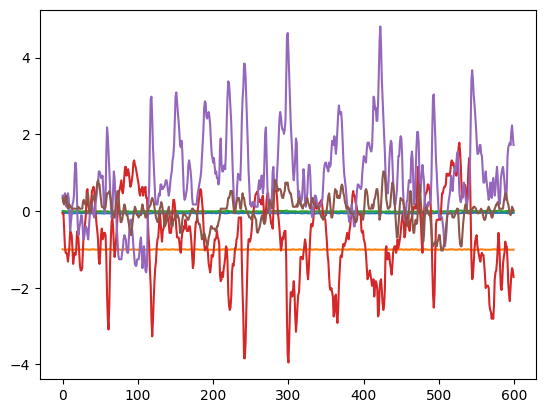

In [11]:
plt.plot(dataset[0].transpose())

In [12]:
X = X / 255.0

lb = LabelBinarizer()
y = lb.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
model = Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,490 (2.61 MB)

 Trainable params: 684,490 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
train_accs = []
test_accs = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

for train_index, test_index in kfold.split(dataset, labels):
    _, gyro_dim, data_len = dataset.shape

    X_train = dataset[train_index]
    X_test = dataset[test_index]

    X_train = X_train.reshape(X_train.shape[0], gyro_dim, data_len, 1)
    X_test = X_test.reshape(X_test.shape[0], gyro_dim, data_len, 1)

    y_train = labels[train_index].reshape(-1, 1)
    y_test = labels[test_index].reshape(-1, 1)

    ohe = OneHotEncoder(sparse_output=False)
    y_train = ohe.fit_transform(y_train)
    y_test = ohe.transform(y_test)

    cnn = Sequential()
    cnn.add(Input(shape=(gyro_dim, data_len, 1)))
    cnn.add(Conv2D(filters=32, kernel_size=(2,2), strides=2, padding='same', activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    cnn.add(Conv2D(filters=16, kernel_size=(2,2), strides=2, padding='same', activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    cnn.add(Flatten())
    cnn.add(Dense(units=64, activation='relu'))
    cnn.add(Dense(units=32, activation='relu'))
    cnn.add(Dense(units=16, activation='relu'))
    cnn.add(Dense(units=5, activation='softmax'))

    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = cnn.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), verbose=0)

    _, train_acc = cnn.evaluate(X_train, y_train, verbose=0)
    _, test_acc = cnn.evaluate(X_test, y_test, verbose=0)

    print('---------------------')
    print(f'Fold no: {fold}')
    print(f'Train Accuracy: {train_acc * 100:.2f}% || Test Accuracy: {test_acc * 100:.2f}%')

    train_accs.append(train_acc)
    test_accs.append(test_acc)

    fold += 1

train_avg = np.mean(train_accs)
test_avg = np.mean(test_accs)

print()
print(f'Train Avg Acc: {train_avg:.5f}')
print(f'Test Avg Acc: {test_avg:.5f}')

---------------------
Fold no: 1
Train Accuracy: 100.00% || Test Accuracy: 96.58%
---------------------
Fold no: 2
Train Accuracy: 100.00% || Test Accuracy: 97.44%
---------------------
Fold no: 3
Train Accuracy: 100.00% || Test Accuracy: 98.29%
---------------------
Fold no: 4
Train Accuracy: 100.00% || Test Accuracy: 96.58%
---------------------
Fold no: 5
Train Accuracy: 100.00% || Test Accuracy: 95.69%

Train Avg Acc: 1.00000
Test Avg Acc: 0.96916


In [15]:
X_train_final = dataset.reshape(dataset.shape[0], dataset.shape[1], dataset.shape[2], 1)
y_train_final = ohe.fit_transform(labels.reshape(-1, 1))

model = Sequential([
    Input(shape=(dataset.shape[1], dataset.shape[2], 1)),
    Conv2D(32, (2, 2), strides=2, padding='same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16, (2, 2), strides=2, padding='same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_final, y_train_final, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.4642 - loss: 2.5863 - val_accuracy: 0.0000e+00 - val_loss: 5.3162
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8307 - loss: 0.4244 - val_accuracy: 0.0940 - val_loss: 3.7729
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8765 - loss: 0.2684 - val_accuracy: 0.1282 - val_loss: 3.7298
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9155 - loss: 0.1549 - val_accuracy: 0.1111 - val_loss: 4.1861
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9151 - loss: 0.1603 - val_accuracy: 0.1282 - val_loss: 4.2043
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9740 - loss: 0.1007 - val_accuracy: 0.1453 - val_loss: 4.0166
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9933 - loss: 0.1067 - val_accuracy: 0.1880 - val_loss: 3.9396
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9931 - loss: 0.1340 - val_accuracy: 0.2137

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9269 - loss: 0.6959 
Test accuracy: 0.8275862336158752


In [19]:
model.save("../../assets/model/update_v2/no_resampling/model.h5")
keras.saving.save_model(model, "../../assets/model/update_v2/no_resampling/model.keras")
model.save_weights("../../assets/model/update_v2/no_resampling/model_weight.weights.h5")

print("Save done!")

Save done!
